# Machine Learning Pipeline

Summary:
- Use Machine Learning to decide whether to buy or to sell
- The features to use are the time-series of the data along with the indicators
- The prediction is either a positive (buy) or negative(sell)
- The "target" for the supervised learning is derrived from the "5 day average future price" 

In [1]:
# %load_ext lab_black
%load_ext autotime

In [2]:
from datetime import datetime, timedelta, date
import requests
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from fastquant import backtest
from fastquant import get_stock_data
from fastquant.data.stocks.pse import get_pse_data_old, get_pse_data

import numpy as np

np.set_printoptions(suppress=True)


pd.options.display.max_columns = 50
pd.options.display.max_rows = 300

time: 1.29 s


In [3]:
start_date = "2010-01-01"
end_date = "2020-11-11"

df = get_pse_data_old("JFC", start_date, end_date)

Loaded:  /home/benj/python-notebooks/quant-notebooks/fastquant/python/fastquant/data/stock_table.csv
time: 2.39 s


In [4]:
df.tail()

,open,high,low,close,value
dt,,,,,
2020-11-05,185.0,199.0,184.8,194.2,389525056.0
2020-11-06,194.4,197.0,188.1,196.8,341265290.0
2020-11-09,197.0,201.2,195.0,198.9,223898920.0
2020-11-10,198.5,201.8,196.0,200.2,421466222.0
2020-11-11,200.2,200.2,196.0,196.5,260145601.0


time: 9.29 ms


# Custom indcator outisde fastquant
- You can also include other features such as Natural Language Processing for sentiments
- As long as you can represent in a time-series context

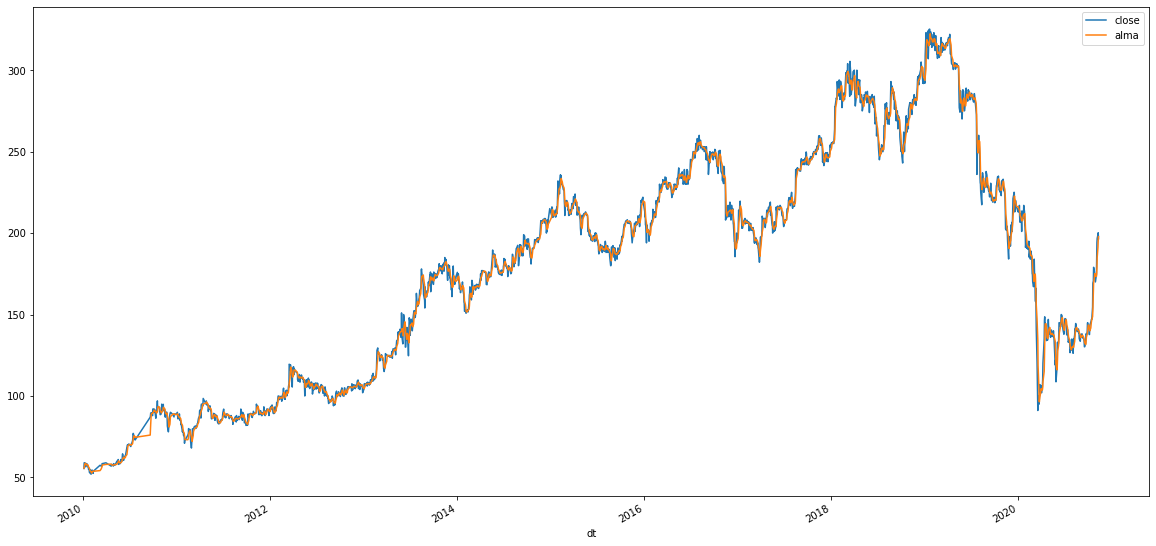

time: 484 ms


In [5]:
%matplotlib inline
from scipy.ndimage import convolve1d as conv
def alma_indicator(data, window=9, offset=0.85, sigma=6):
    m = int(offset * window - 1)
    s = window / sigma
    dss = 2 * s * s
    wtds = np.exp(-((np.arange(window) - m) ** 2) / dss)
    return conv(data, weights=wtds / wtds.sum(), axis=0, mode="nearest")


# %matplotlib inline
df["alma"] = alma_indicator(df.close, window=9, offset=0.85, sigma=6)



df[["close", "alma"]].plot(figsize=(20, 10))

# Specify which indicators to use

In [6]:
from fastquant import CustomStrategy, BaseStrategy
from fastquant.indicators import MACD, CrossOver,RelativeStrengthIndex,AverageTrueRange,CommodityChannelIndex,ParabolicSAR,Stochastic,WilliamsR,Envelope, BollingerBands,CustomIndicator
from backtrader.indicators import MACDHisto, MACDHistogram





class AddIndicatorStrategy(BaseStrategy):

    def __init__(self):
        super().__init__()
    

        # Add indiactor from DataFrame
        self.alma = add_custom_indicator(self,"alma","alma")
        self.alma_crossover = add_crossover_indicator(self.dataclose,self.alma,"alma crossover")
        
        # Add Built-in indicators
        self.macd_histogram = MACDHistogram(
            period_me1=12,
            period_me2=16,
            period_signal=9,
        )
        self.rsi_ind = RelativeStrengthIndex(period=14) 
        self.atr_ind = AverageTrueRange(period=14)
        self.cci_ind = CommodityChannelIndex(period=20,factor=0.015)
        self.bbands_ind = BollingerBands(period=20,devfactor=0.2)
        
# Inherit the AddIndicator to include the original indicators
class MLStrategy(AddIndicatorStrategy):

    def __init__(self):
        super().__init__()
        self.action_indicator = add_custom_indicator(self,"action","action",subplot=True)
        
    def buy_signal(self):
        return self.action_indicator[0] > 0

    def sell_signal(self):
        return self.action_indicator[0] < 0
        

def add_custom_indicator(self, column_name, plotname, subplot=False):
    
    ind = CustomIndicator(self.data, custom_column=column_name)
    ind.plotinfo.plotname = "alma"
    ind.plotinfo.subplot=subplot  # To plot with the data
    return ind


def add_crossover_indicator(indicator1,indicator2,plotname=None):
    crossover = CrossOver(indicator1,indicator2)
    if plotname is not None:
        crossover.plotinfo.plotname = plotname
    return crossover


def get_indicators(df, indicator_strat):
    # Run Backtest and get the indicator history, then merge with the original df
    result, history = backtest(indicator_strat, df, verbose=0, return_history=True, plot=False)
    data_ind_df = df[["open","high","low","close","value"]].merge(history['indicators'], left_on="dt", right_on="dt").copy()
    data_ind_df.drop(columns=["strat_id","strat_name"],inplace=True)
    data_ind_df.set_index("dt",inplace=True)
    return data_ind_df


time: 4.02 ms


In [7]:
data_ind_df = get_indicators(df,AddIndicatorStrategy)

time: 1.19 s


In [8]:
data_ind_df.tail(5)

,open,high,low,close,value,alma,alma_crossover,MACDHistogram_macd_12_16_9,MACDHistogram_signal_12_16_9,MACDHistogram_histo_12_16_9,RelativeStrengthIndex_14,AverageTrueRange_14,CommodityChannelIndex_20_0.015,BollingerBands_mid_20_0.2,BollingerBands_top_20_0.2,BollingerBands_bot_20_0.2
dt,,,,,,,,,,,,,,,,
2020-11-05,185.0,199.0,184.8,194.2,389525056.0,178.927533,0.0,3.784980,3.186817,0.598164,81.723250,6.233660,126.612697,164.085,167.169518,161.000482
2020-11-06,194.4,197.0,188.1,196.8,341265290.0,185.001992,0.0,4.157103,3.380874,0.776229,82.632516,6.424113,112.051680,166.790,170.022256,163.557744
2020-11-09,197.0,201.2,195.0,198.9,223898920.0,191.258809,0.0,4.435708,3.591841,0.843867,83.352896,6.408105,110.710636,169.545,172.883997,166.206003
2020-11-10,198.5,201.8,196.0,200.2,421466222.0,195.713041,0.0,4.610491,3.795571,0.814920,83.800842,6.364669,98.122203,172.285,175.685307,168.884693
2020-11-11,200.2,200.2,196.0,196.5,260145601.0,197.796673,-1.0,4.523601,3.941177,0.582424,77.415854,6.210050,79.337144,174.835,178.157627,171.512373


time: 13.1 ms


# Add proxy "Target" for supervised learning

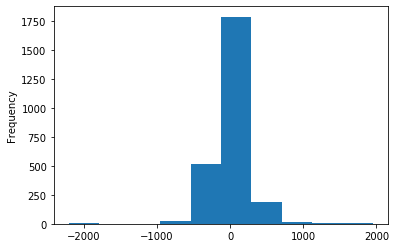

time: 286 ms


In [9]:
def future_pct_change(df):
    """
    Get the percent change between today and the average price for the next 5 days
    """
    df_dict = df.to_dict(orient="list")

    changes = []
    for day in range(0, df.shape[0]):

        current_close = df_dict["close"][day]

        next_days = df_dict["close"][day : day + 5]
        next_days_ave = np.mean(next_days)

        pct_change = (next_days_ave - current_close) / current_close *100

        changes.append(pct_change * 100)

    return changes

# future_pct_change(data_ind_df)

data_ind_df["pct_change"] = future_pct_change(data_ind_df)
data_ind_df["pct_change"].plot(kind="hist")

# Data Preprocessing
- Data Normalization
- Select which colums should be normalized

In [10]:
# Set Windowsize And Normalize
non_normalized_cols = ["value"]
price_normalized_cols = (
    ["open","high","low","close"] + 
    ["alma"] + 
    [c for c in data_ind_df.columns if "BollingerBands" in c ]
)
min_max_normalized_cols = (
    [c for c in data_ind_df.columns if "CommodityChannelIndex" in c ],
    [c for c in data_ind_df.columns if "AverageTrueRange" in c ],
    [c for c in data_ind_df.columns if "MACD" in c ]
)


price_normalized_cols = (
    ["open","high","low","close"] 
)


target_col = "pct_change"
price_normalized_cols

['open', 'high', 'low', 'close']

time: 2.85 ms


# TimeSeries Window
### Concept: When people to Chart Analysis, they analyze patterns based on what's "visible" on the screen.
- The most important here are the shapes, and relative position of the incators from each other
- The numeric values of prices and moving averages and other indicators matters less
- Different assets/stocks have different numeric prices but the pattern matching will be the same

In [11]:


def get_window(df, day, window_size=50, normalized=True):
    w = df[day-window_size:day]
    if normalized:
        return normalize_window(w)
    else:
        return w.copy()
    
def normalize_window(window):
    normed_window = window.copy()
    min_price = window[["open","high","low","close"]].values.min()
    max_price = window[["open","high","low","close"]].values.max()
    
    for col in price_normalized_cols:
    # Normalize Base on price
        normed_window.loc[:,col] = (window.loc[:,col] - min_price) / (max_price - min_price)
        
    # Normalize Based on Min-Max
    for col in min_max_normalized_cols:
        pass
    
    return normed_window

time: 91.8 ms


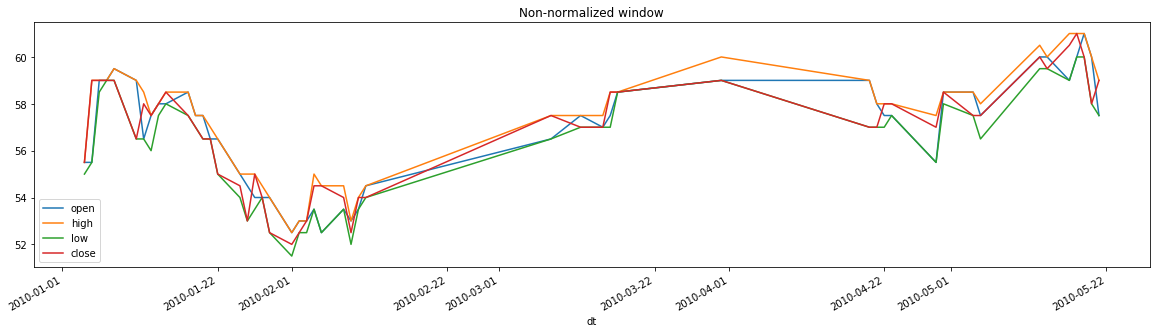

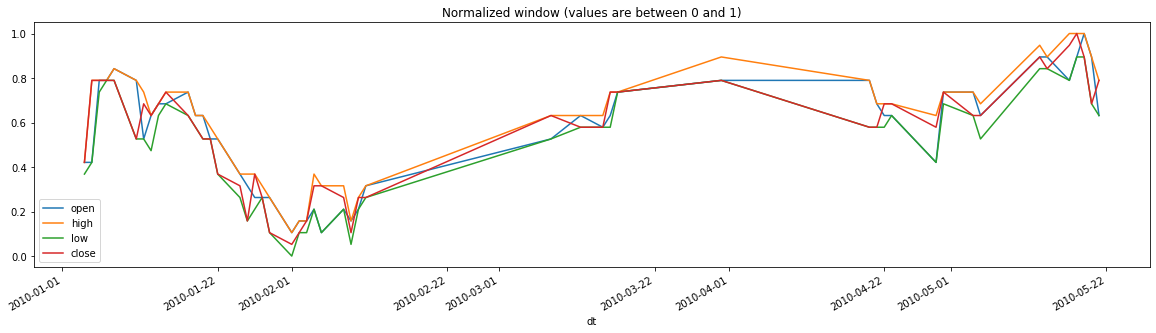

time: 651 ms


In [12]:
window = get_window(data_ind_df,50,50, normalized=False)
window[price_normalized_cols].plot(figsize=(20,5), title="Non-normalized window")

window = get_window(data_ind_df,50,50, normalized=True)
window[price_normalized_cols].plot(figsize=(20,5), title="Normalized window (values are between 0 and 1)")

# Machine Learning (Data Prep)

- Each window will be specifed bv (`day`, `window`) where the window includes the `day`-th day and the `window`-previous days based on the window
- Inputs will be a sequence of windows 
- Target value will come from the last day of the window
- The first N windows containing NaN from indicators will be ignored (`NaN_window_count`)
- The ML prediction will start on the `window` + `NaN_window_count` until the last window
- If window_size = 15 and 38 `nan_window`s, the first 53(15+38=53) will have no predictions

In [13]:
def extract_X_y(df,window_size=10):

    X, y = [],[]

    for d in range(window_size, df.shape[0]):
        window = get_window(df, day=d,window_size=window_size, normalized=True)          
        target = window.iloc[-1][target_col] # last value
        X.append(window.drop(columns=target_col))   
        y.append(target)
        
    return X,y
   
def window_has_nan(df):
    return df.isna().values.sum() > 0

def remove_nans(X,y):
    # TO DO: FIND BETTER WAY TO DO THIS 
    # ALSO convert to numpyarray then flatten
    xx,yy = [],[]
    nan_count = 0
    for x,y_ in zip(X,y):
        if not window_has_nan(x):
            xx.append(x.values.flatten()) 
            yy.append(y_)
        else:
            nan_count += 1
    return xx,yy, nan_count

time: 1.9 ms


# Train ML Model (check training performance)

In [14]:
window_size = 15

X,y = extract_X_y(data_ind_df,window_size=window_size)
print(len(X), len(y))
X,y, nan_count = remove_nans(X,y)
print(len(X), len(y))

2517 2517
2479 2479
time: 9.03 s


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# regressor = RandomForestRegressor(n_estimators=50,n_jobs=6)
regressor = LinearRegression(n_jobs = 6)
f_ = regressor.fit(X,y)
preds = regressor.predict(X)
mae = mean_absolute_error(y,preds)
mse = mean_squared_error(y,preds)
print(mae,mse)


53.98222932733562 6777.585604521817
time: 1.3 s


In [16]:


# Add actions with zero padding
empty_preds = np.zeros(nan_count + window_size )
actions = empty_preds.tolist() + preds.tolist()
data_ind_df["action"] = actions

time: 10.3 ms


<IPython.core.display.Javascript object>

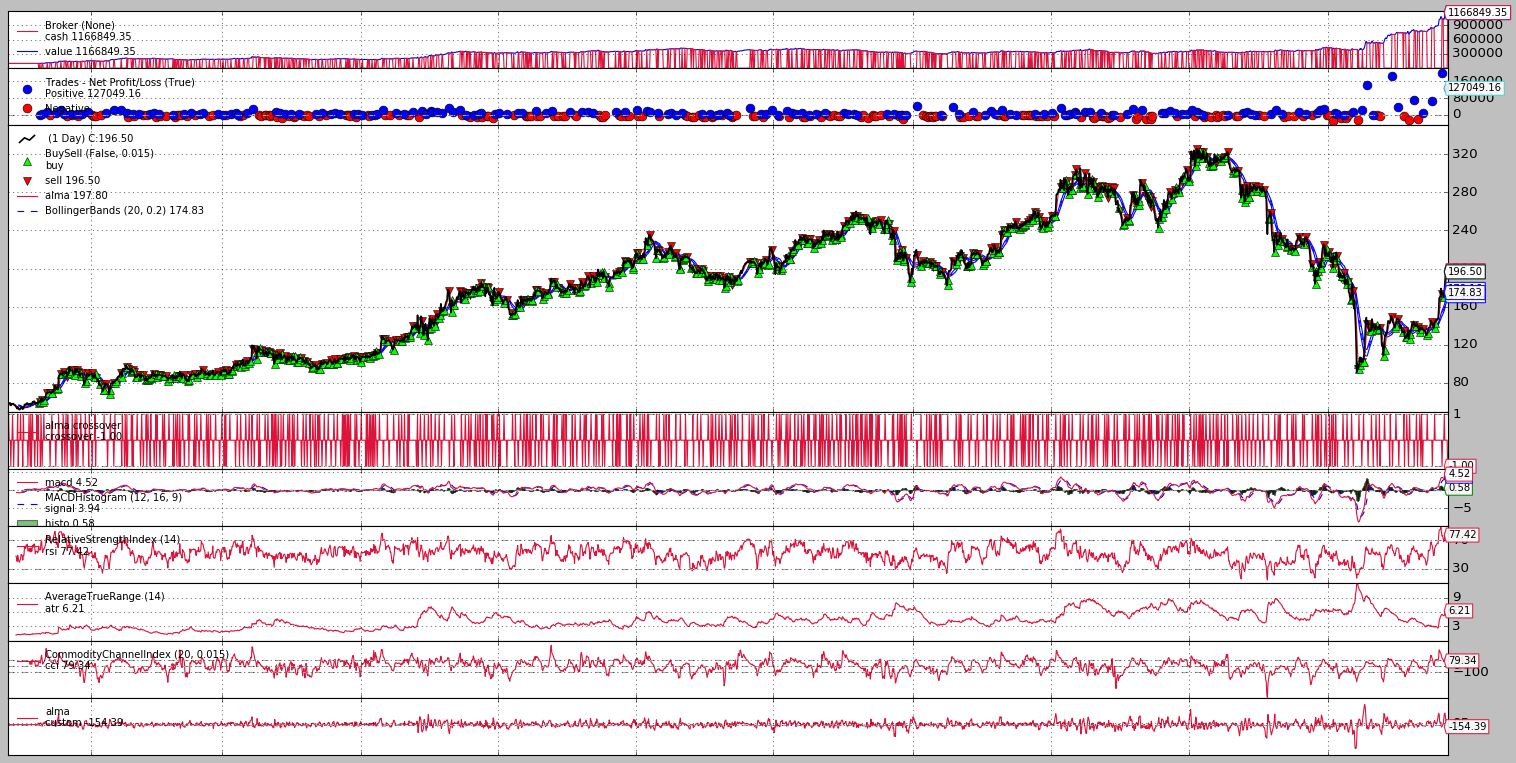

time: 7.48 s


In [17]:
result, history = backtest(
    MLStrategy, data_ind_df, verbose=0, return_history=True, plot=True, figsize=(20,10)
)

In [18]:
result.final_value.iloc[0]

1166849.3523749996

time: 1.82 ms


# Test on other stock

In [19]:
start_date = "2010-01-01"
end_date = "2020-11-11"

test_df = get_pse_data_old("CHP", start_date, end_date)

Loaded:  /home/benj/python-notebooks/quant-notebooks/fastquant/python/fastquant/data/stock_table.csv
time: 664 ms


In [20]:
# Add ALMA indicator
test_df["alma"] = alma_indicator(test_df.close, window=9, offset=0.85, sigma=6)

# Add indicators
test_data_ind_df = get_indicators(test_df,AddIndicatorStrategy)

# Add Target
test_data_ind_df["pct_change"] = future_pct_change(test_data_ind_df)

time: 459 ms


In [21]:
window_size = 15

# Prepare Data
X,y = extract_X_y(test_data_ind_df,window_size=window_size)
print(len(X), len(y))
X,y, nan_count = remove_nans(X,y)
print(len(X), len(y))

1039 1039
1001 1001
time: 3.65 s


In [22]:
# Test Preds

test_preds = regressor.predict(X)
preds = regressor.predict(X)
mae = mean_absolute_error(y,preds)
mse = mean_squared_error(y,preds)
print(mae,mse)

264.46254217606406 120087.49445721663
time: 33.6 ms


In [23]:

# Add actions with zero padding
empty_preds = np.zeros(nan_count + window_size )
actions = empty_preds.tolist() + test_preds.tolist()
test_data_ind_df["action"] = actions

time: 108 ms


<IPython.core.display.Javascript object>

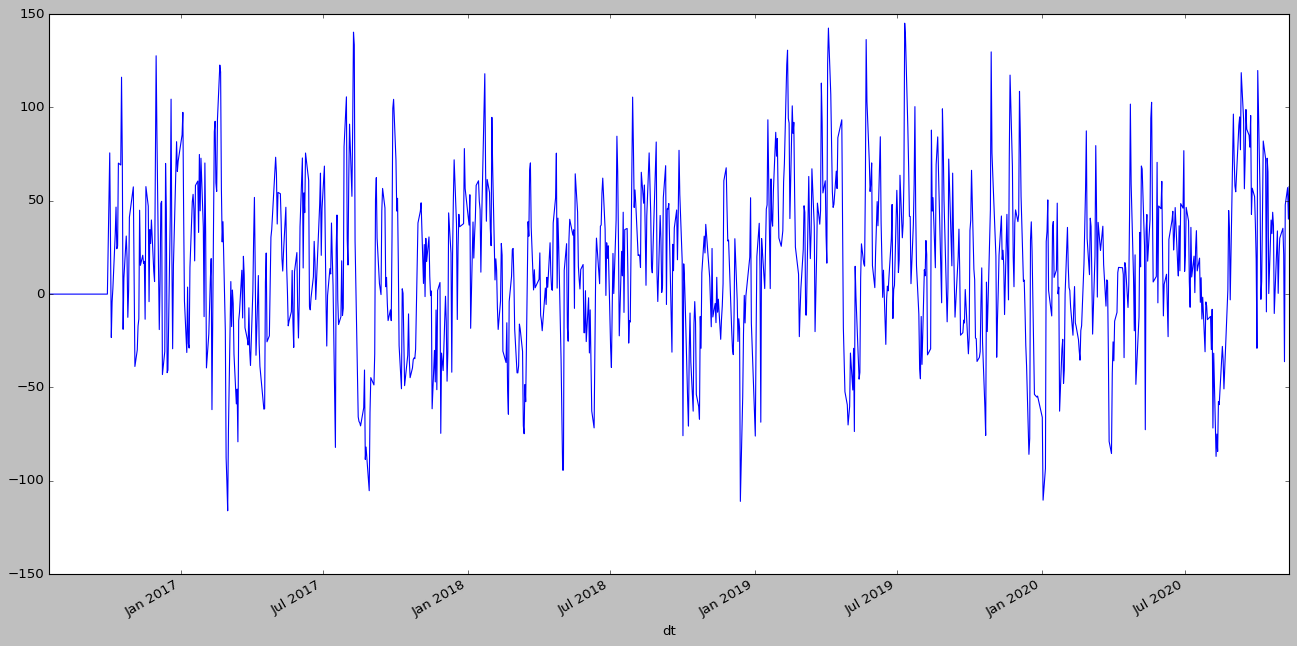

time: 540 ms


In [24]:
test_data_ind_df["action"].plot()

<IPython.core.display.Javascript object>

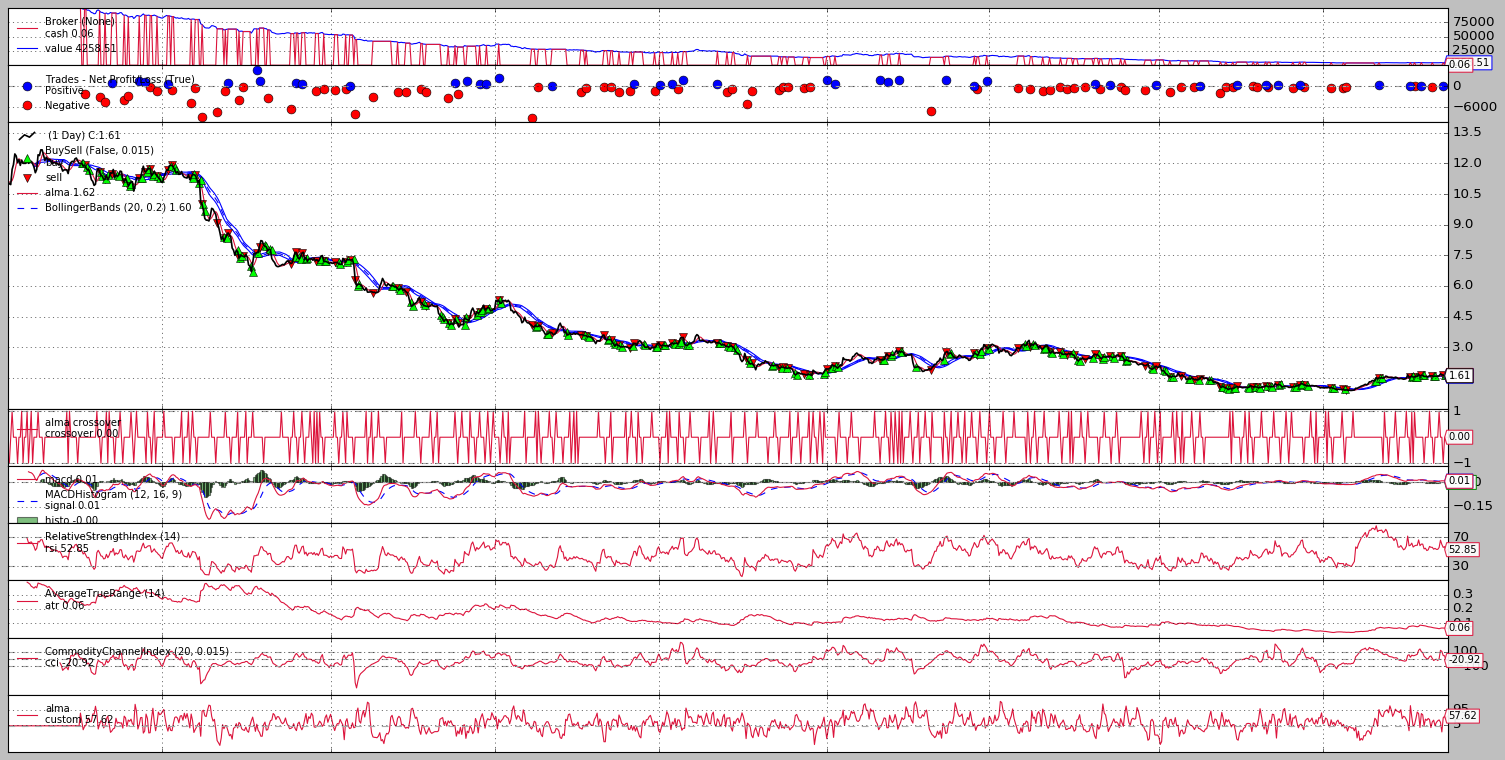

time: 4.53 s


In [25]:
result, history = backtest(
    MLStrategy, test_data_ind_df, verbose=0, return_history=True, plot=True, figsize=(20,10)
)

In [26]:
result.final_value.iloc[0]

4258.506575000014

time: 1.66 ms


In [27]:
sells = history["orders"]
sells = sells[sells.type == "sell"]
sells.sort_values(by='pnl')

,strat_id,strat_name,dt,type,price,size,value,commission,pnl
127,0,,2018-02-09,sell,4.08,-6914,36643.15,211.568400,-8434.03
43,0,,2017-02-13,sell,9.99,-7165,79245.74,536.837625,-7667.39
88,0,,2017-07-27,sell,6.30,-7168,52326.40,338.688000,-7168.00
213,0,,2019-04-25,sell,1.90,-7275,20514.28,103.668750,-6691.78
46,0,,2017-02-28,sell,9.09,-7059,70517.31,481.247325,-6351.00
66,0,,2017-05-19,sell,7.09,-7856,61276.64,417.742800,-5577.60
179,0,,2018-10-03,sell,2.36,-7346,22036.80,130.024200,-4700.24
37,0,,2017-02-01,sell,11.30,-7151,84380.96,606.047250,-3574.66
8,0,,2016-10-27,sell,11.22,-8108,94051.20,682.288200,-3079.44
52,0,,2017-03-22,sell,7.38,-8076,62589.00,447.006600,-2988.12


time: 105 ms


<IPython.core.display.Javascript object>

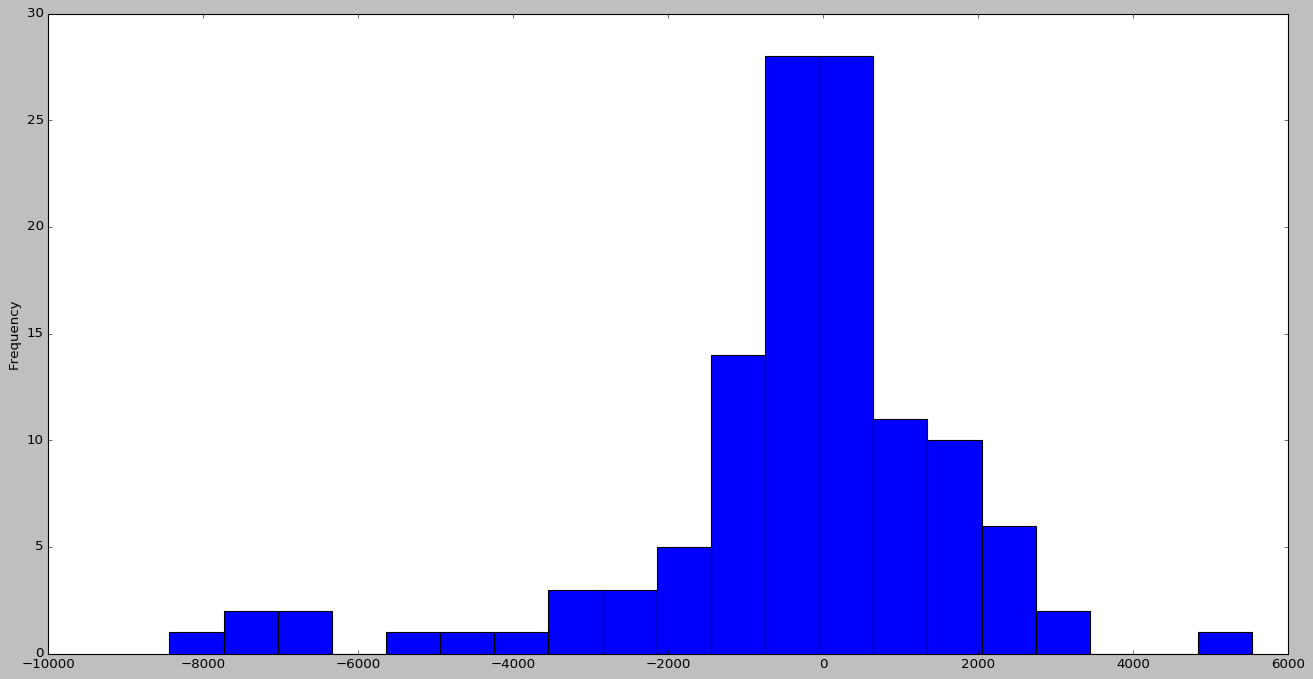

time: 432 ms


In [28]:
sells.pnl.plot(kind="hist",bins=20)